In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn


You should consider upgrading via the 'C:\Users\Bogdan\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod

In [3]:
# Abstract Class for Preprocessing
class Preprocessor(ABC):
    def __init__(self, dataset, target):
        self.dataset = dataset
        self.target = target

    def clean_data(self):
        df = self.dataset.copy()
        df = df.drop_duplicates()

        # Fill missing values
        for column in df.select_dtypes(include=["number"]).columns:
            df[column] = df[column].fillna(df[column].mean())
        for column in df.select_dtypes(include=["object"]).columns:
            df[column] = df[column].fillna(df[column].mode()[0])

        # Encode categorical features
        df = pd.get_dummies(df, drop_first=True)
        self.dataset = df
        return df

    def split_data(self, test_size=0.2, random_state=42):
        X = self.dataset.drop(columns=[self.target])
        y = self.dataset[self.target]
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

    def visualize_heatmap(self):
        """
        Generate a heatmap of the correlation matrix for numerical features.
        """
        correlation_matrix = self.dataset.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()


# Abstract Class for Model Training and Evaluation
class ModelPipeline(ABC):
    def __init__(self, model, model_type):
        self.model = model
        self.model_type = model_type

    @abstractmethod
    def train(self, X_train, y_train):
        pass

    @abstractmethod
    def evaluate(self, model, X_test, y_test):
        pass

    def optimize(self, X_train, y_train, param_grid):
        grid_search = GridSearchCV(
            self.model,
            param_grid,
            cv=5,
            scoring="accuracy" if self.model_type == "classification" else "neg_mean_squared_error",
        )
        grid_search.fit(X_train, y_train)
        print(f"Best Parameters: {grid_search.best_params_}")
        return grid_search.best_estimator_


# Concrete Class for Classification
class ClassificationPipeline(ModelPipeline):
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self.model

    def evaluate(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


# Concrete Class for Regression
class RegressionPipeline(ModelPipeline):
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self.model

    def evaluate(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        print(f"MSE: {mean_squared_error(y_test, y_pred)}")
        print(f"R2 Score: {r2_score(y_test, y_pred)}")

        # Actual vs Predicted scatter plot
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test, y_pred, color="blue", label="Predicted", alpha=0.6)
        plt.plot(y_test, y_test, color="red", label="Actual (Ideal)", linestyle="--")
        plt.title("Actual vs Predicted")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.show()



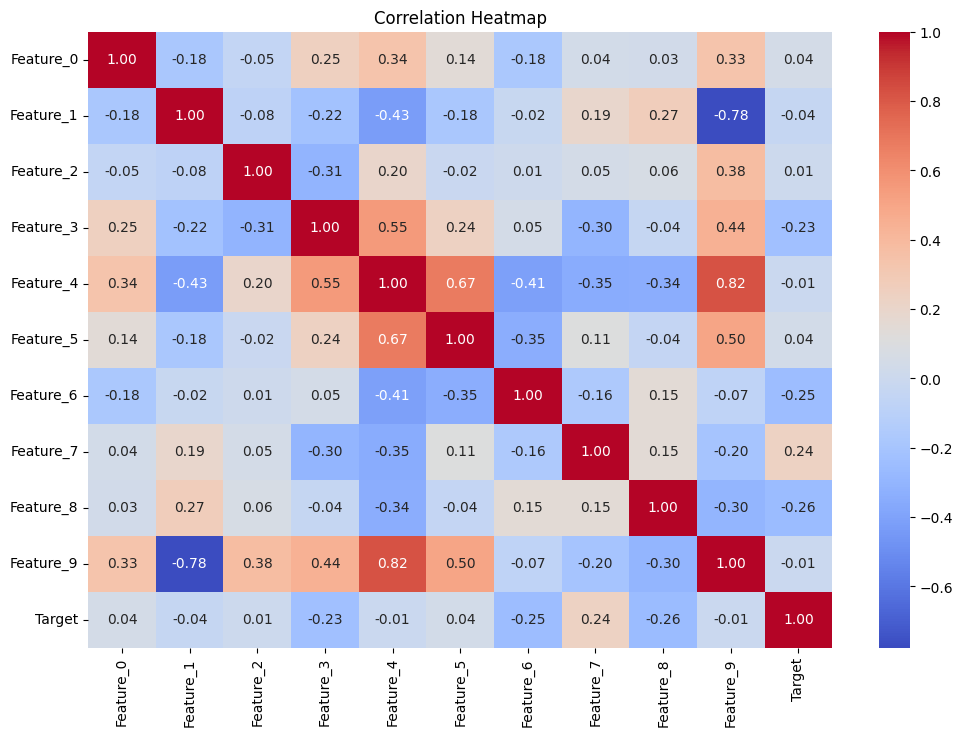


--- Logistic Regression ---
Accuracy: 0.675

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       106
           1       0.63      0.73      0.68        94

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200



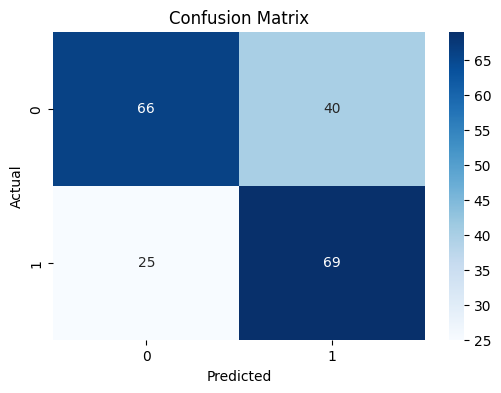


--- Decision Tree Optimization ---
Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       106
           1       0.72      0.71      0.72        94

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



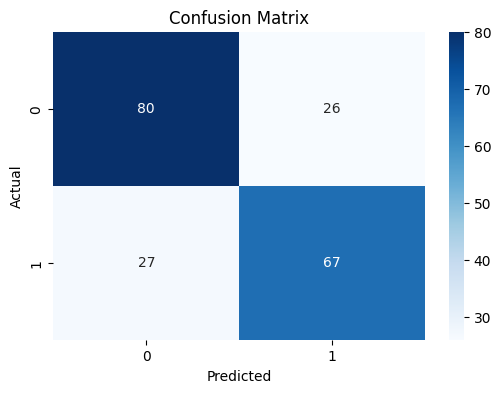

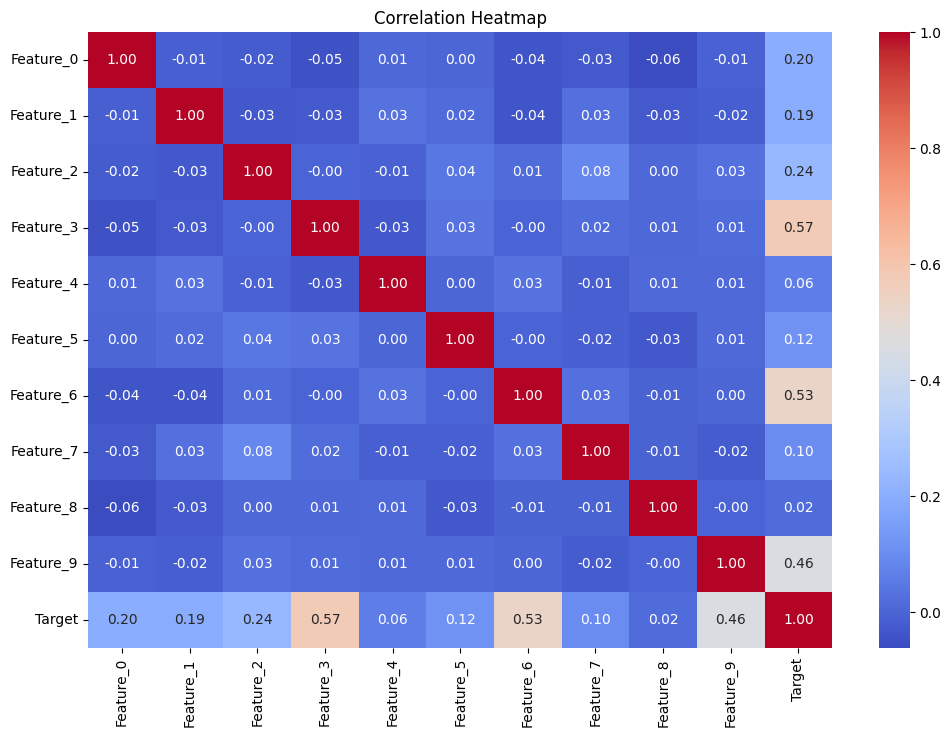


--- Random Forest Regressor ---
MSE: 2620.1373788454684
R2 Score: 0.8446786363593848


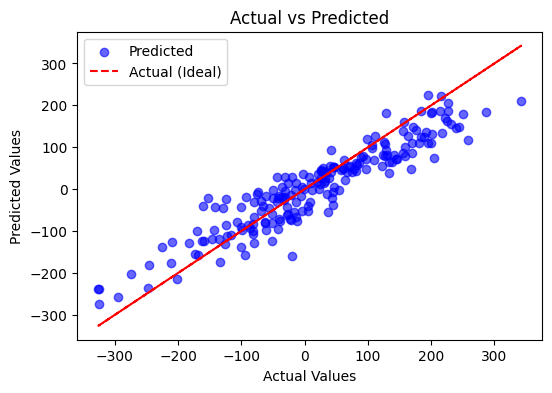


--- Linear Regression Optimization ---
Best Parameters: {'fit_intercept': True}
MSE: 0.03804765964168226
R2 Score: 0.9999977445402571


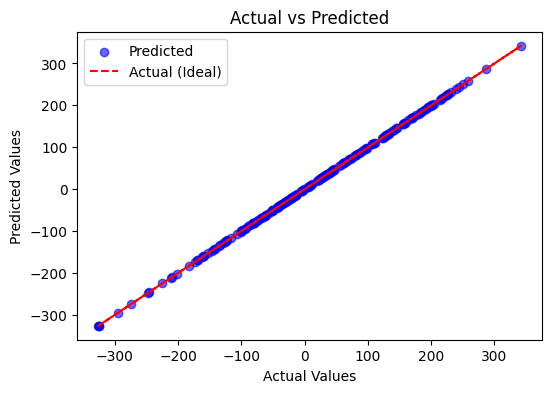

In [4]:
from sklearn.datasets import make_classification, make_regression

# Example for classification
X_class, y_class = make_classification(
    n_samples=1000, n_features=10, n_informative=8, n_redundant=2, random_state=42
)
class_data = pd.DataFrame(X_class, columns=[f"Feature_{i}" for i in range(10)])
class_data["Target"] = y_class

class_preprocessor = Preprocessor(class_data, target="Target")
class_preprocessor.clean_data()
class_preprocessor.visualize_heatmap()  # Generate the heatmap
X_train, X_test, y_train, y_test = class_preprocessor.split_data()

# Train Logistic Regression
print("\n--- Logistic Regression ---")
logistic_pipeline = ClassificationPipeline(LogisticRegression(max_iter=1000), model_type="classification")
logistic_model = logistic_pipeline.train(X_train, y_train)
logistic_pipeline.evaluate(logistic_model, X_test, y_test)

# Optimize Decision Tree
print("\n--- Decision Tree Optimization ---")
dt_pipeline = ClassificationPipeline(DecisionTreeClassifier(), model_type="classification")
param_grid = {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]}
optimized_dt_model = dt_pipeline.optimize(X_train, y_train, param_grid)
dt_pipeline.evaluate(optimized_dt_model, X_test, y_test)

# Example for regression
X_reg, y_reg = make_regression(n_samples=1000, n_features=10, noise=0.2, random_state=42)
reg_data = pd.DataFrame(X_reg, columns=[f"Feature_{i}" for i in range(10)])
reg_data["Target"] = y_reg

reg_preprocessor = Preprocessor(reg_data, target="Target")
reg_preprocessor.clean_data()
reg_preprocessor.visualize_heatmap()  # Generate the heatmap
X_train, X_test, y_train, y_test = reg_preprocessor.split_data()

# Train Random Forest Regressor
print("\n--- Random Forest Regressor ---")
rf_pipeline = RegressionPipeline(RandomForestRegressor(n_estimators=100), model_type="regression")
rf_model = rf_pipeline.train(X_train, y_train)
rf_pipeline.evaluate(rf_model, X_test, y_test)

# Optimize Linear Regression
print("\n--- Linear Regression Optimization ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_pipeline = RegressionPipeline(LinearRegression(), model_type="regression")
param_grid = {"fit_intercept": [True, False]}  # Removed 'normalize' parameter
optimized_lr_model = lr_pipeline.optimize(X_train_scaled, y_train, param_grid)
lr_pipeline.evaluate(optimized_lr_model, X_test_scaled, y_test)
